# Telegram channels topic modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import re
import random
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.cluster import KMeans, HDBSCAN
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from transformers import pipeline
from bertopic.representation import TextGeneration

/home/mykyta/dev/study/nlp_course/homework/.poetry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = '../data/topic-modeling'

## Loading data

In [3]:
dataset = pd.read_csv(f'{DATA_DIR}/KyivChannels_Dataset_v01.csv', converters={'Date': pd.to_datetime})

In [4]:
dataset.head()

channelname                Date  \
0  kyivpolitics 2023-08-01 09:45:38   
1  kyivpolitics 2023-08-01 10:03:38   
2  kyivpolitics 2023-08-01 14:42:31   
3  kyivpolitics 2023-08-01 15:37:34   
4  kyivpolitics 2023-08-01 13:06:08   

                                             content lang  
0  Отбой. Угрозы для столицы нет\n\nКиев. Главное...   ru  
1  На 8 перекрестках Киева в пилотном режиме внед...   ru  
2  ⚡️НБУ отозвал банковскую лицензию Конкорд Банк...   ru  
3  Завтра синоптики прогнозируют небольшой дождь ...   ru  
4  А вот и сам снятый советский герб \n\nКиев. Гл...   ru

In [5]:
dataset.isna().sum(axis=0)

channelname    0
Date           0
content        0
lang           0
dtype: int64

In [6]:
dataset['channelname'].value_counts()

channelname
novynylive                     3590
lossolomas_kyiv                3009
darnicalive                    2715
kievvlast                      2273
vichirniykyiv                  1738
big_kyiv                       1670
kyivpolitics                   1383
nashkyivua                     1366
kyiv_novyny_24                 1102
kievreal1                      1096
huevyi_kiev                    1091
obolonlife                     1070
kiev1                          1006
khreschatyk36                   959
kyiv_n                          809
lisovy_masyv_official           722
poznyakyosokorkykharkivskiy     633
hmarochos                       606
ushkiklichko                    578
semenovatut                     526
kyivpasstrans                   362
kyivpatrol                      313
kyivpastrans_live               280
kyivpassengers                  277
uhmc2022                        271
kyiv_pro_office                 248
kyivcityofficial                247
kyiv_by_grishyn 

Trying to select channels with most diverse topics to train BERTopic:

In [7]:
selected_channels = ['kyivpolitics', 'hmarochos', 'dailykek', 'tsum6', 'pro_mobility']

In [8]:
dataset['lang'].value_counts()

lang
uk    28465
ru     2112
en      147
bg       95
sr       77
be       58
ja       53
kk       39
zh       30
mk       23
mn       22
vi        8
ky        7
pl        5
sk        4
hr        3
qu        3
rw        3
bs        3
bn        2
fi        2
mt        2
ka        2
he        2
de        2
sq        1
mr        1
it        1
da        1
ps        1
sv        1
sl        1
fr        1
nn        1
et        1
hu        1
zu        1
hi        1
Name: count, dtype: int64

### Number of posts per day

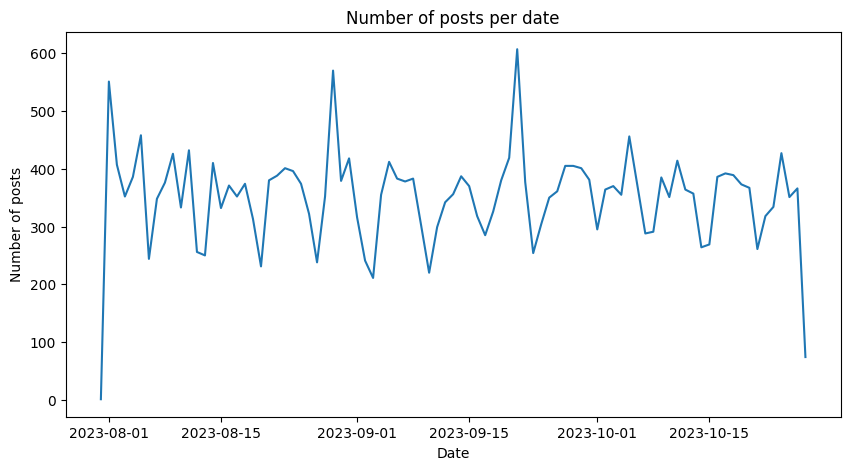

In [9]:
plt.figure(figsize=(10, 5))
dates = dataset['Date'].apply(lambda d: d.date())
dates.groupby(dates).count().plot()
plt.xlabel('Date')
plt.ylabel('Number of posts')
plt.title('Number of posts per date');

## Text processing

Since dataset consists of Kyiv telegram chennels, Kyiv will be treated as a stopword.

In [10]:
dataset['content'].sample(5).to_list()

['🍂 Осінь у Києві, як окремий вид мистецтва\n\nТак затишно🥰 \n\nА у вас є фото нашого міста восени? Діліться у коментарях👇\n\nКиїв — пряма трансляція 👈\nНадіслати новину',
 '❗️Демонтаж радянського герба з монумента Батьківщина-Мати завершено\n\nПрацівники змогли зняти радянський герб з монумента і вже розпочали подальші роботи.\n\nВеликий Київ | Приєднатися',
 'У трьох селах Бориспільщини модернізують водовідведення.\n\n🤝Виконавчий комітет Вороньківської сільської ради заключив три договори з ФОП “Бєлов Олександр Юрійович” на розробку проектно-кошторисної документації при реконструкції систем водопостачання та водовідведення👉 у селах Мирне, Старе та Головурів Вороньківської громади.',
 'Німеччина дозволила виробнику зброї Rheinmetall створити спільне з Україною підприємство, - Spiegel\n\nКомпанія займатиметься виробництвом та обслуговуванням військової техніки безпосередньо на території України.\n\n👉👉Запропонувати новину👈👈\n\nПідписатись на Дарниця Livе',
 '❗️Зустрічайте новий формат н

In [11]:
def load_stopwords(file_name):
    stopwords = []
    with open(file_name, 'r') as f:
        for line in f:
            stopwords.append(line.rstrip('\n'))
    return stopwords

nltk.download('punkt')
nltk.download('stopwords')
custom_stopwords = [
    'instagram', 'facebook', 'telegram', 'tiktok', 'viber', 'live', 'livе', 'підписатися', 'приєднатися', 'підписатись',
    'надіслати', 'новину', 'запропонувати', 'главное', 'хуйовий', 'трансляція', 'новини', 'підписуйтесь', 'киев', 'политика',
    'посиланням', 'читайте', 'відео', 'київ', 'великий', 'дарниця', 'києві'
]
stopwords = list(set(
    nltk.corpus.stopwords.words('english') +
    nltk.corpus.stopwords.words('russian') +
    load_stopwords('stopwords_ua.txt') +
    custom_stopwords
))

[nltk_data] Downloading package punkt to /home/mykyta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mykyta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def remove_whitespaces(text):
    text = re.sub('\n+', '. ', text)
    text = re.sub('\ *\.[\.\ ]*', '. ', text)
    text = re.sub('\ *[!?;]\ *\.\ *', '. ', text)
    text = re.sub('\ *:\ *\.\ *', ': ', text)
    text = re.sub('\ +', ' ', text)
    text = re.sub('|', '', text)
    return text

def remove_emojies(text):
    return emoji.replace_emoji(text)

def remove_links(text):
    text = re.sub('\S*@\S+', '', text)
    text = re.sub('https?://\S+', '', text)
    text = re.sub('#\S+', ' ', text)
    return text

def remove_numbers(text):
    text = re.sub('\d-?\S*', '', text)
    text = re.sub('№', '', text)
    return text

def filter_stopwords(text):
    text = nltk.tokenize.word_tokenize(text)
    text = [word for word in text if word not in stopwords]
    return " ".join(text)

def process_text(text):
    text = text.lower()
    text = remove_emojies(text)
    text = remove_links(text)
    text = remove_numbers(text)
    text = remove_whitespaces(text)
    text = filter_stopwords(text)
    return remove_whitespaces(text)

In [13]:
dataset['processed_content'] = dataset['content'].apply(process_text)

In [14]:
dataset['processed_content'].sample(5).to_list()

['бельгії зник футболіст « шахтаря ». олександр роспутько приїхав аеропорт матчу , знайшли форму , гравець видалив публікації соцмережах перестав відповідати дзвінки. цікаво , контракт футболіст підписав шахтарем днів , чином отримав можливість виїхати кордон. ',
 'киянин toyota land cruiser вбив трьох людей львівщині. вранці лобовому зіткненні автомобілів трускавця загинуло троє людей. четверо пасажирів травмами госпіталізовані лікарні. попередня причина аварії – киянин виїхав зустрічну смугу. затриманий , скоєне загрожує позбавлення волі. |',
 'затори жесть',
 'дпсу розповіли внесення змін правил перетинання держкордону. стверджують , студентів курсантів закладів освіти україни , їдуть кордон проходження практичної льотної підготовки іноземні заклади освіти авіаційні школи пропускатимуть кордон наявності підтверджуючих документів. зокрема , : довідку закладу освіти україни направлення проходження практичної льотної підготовки іноземному закладі освіти авіаційній школі. військово-облі

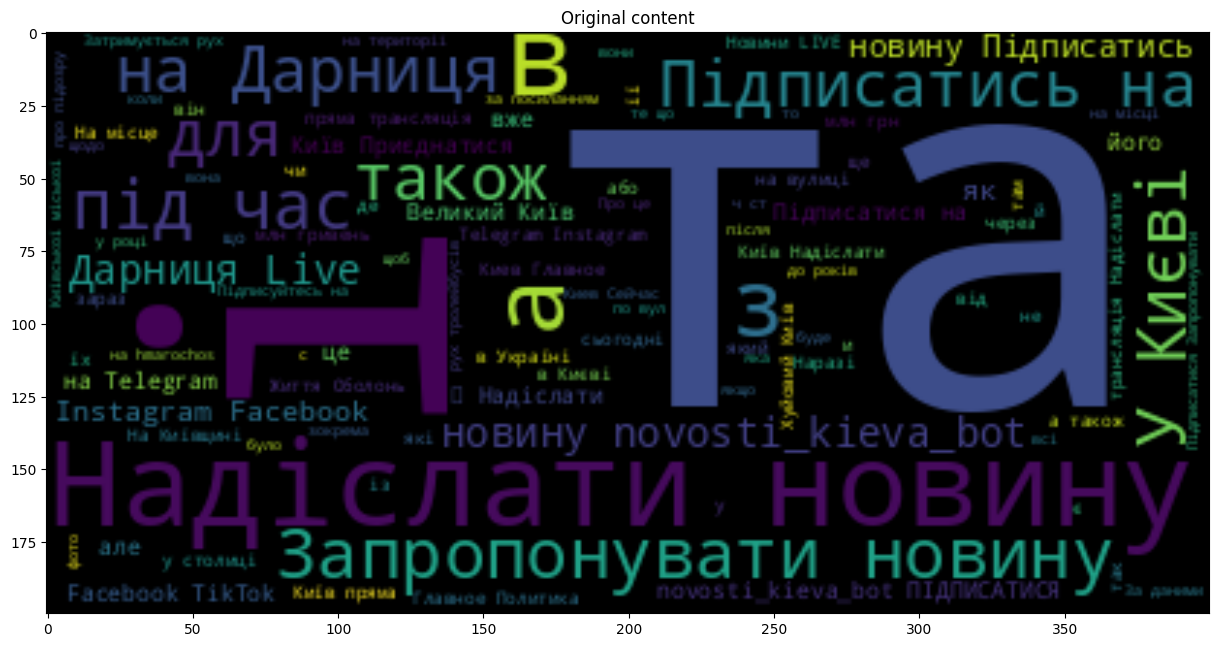

In [15]:
plt.figure(figsize=(15, 20))
plt.title('Original content')
cleand_wc = WordCloud(max_words=500).generate(' '.join(dataset['content']))
plt.imshow(cleand_wc, interpolation='bilinear');

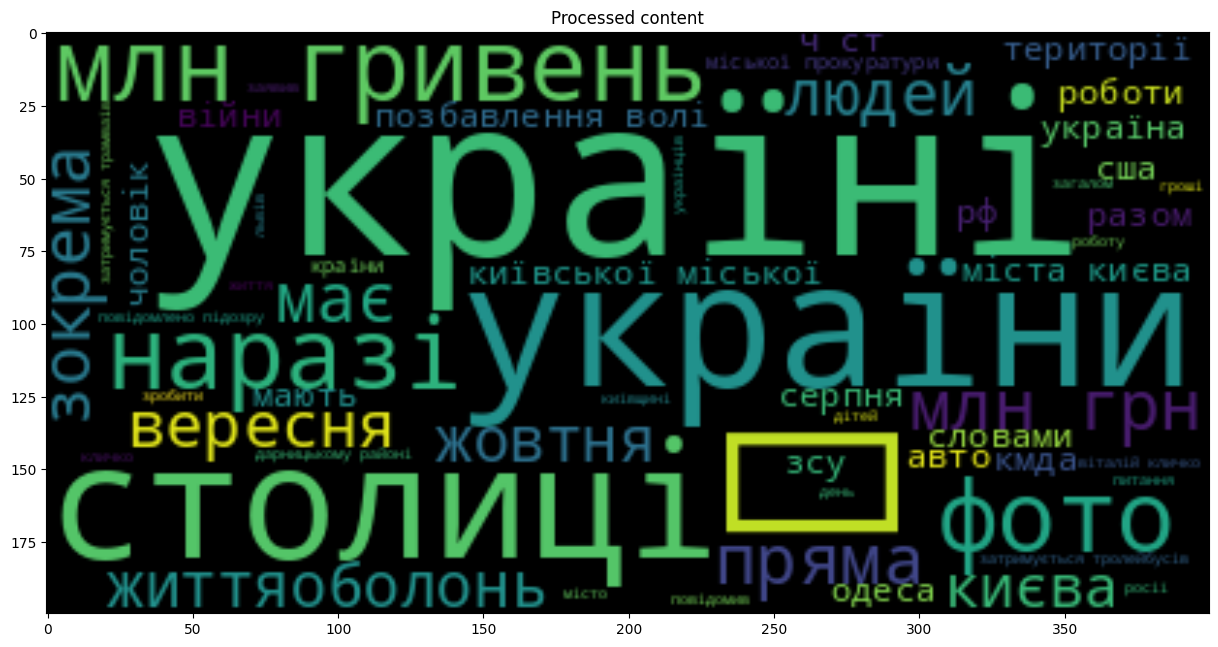

In [16]:
plt.figure(figsize=(15, 20))
plt.title('Processed content')
cleand_wc = WordCloud(max_words=500).generate(' '.join(dataset['processed_content']))
plt.imshow(cleand_wc, interpolation='bilinear');

As we can see, processed content consists of much more relevant words.

## Sentence embedding

In [17]:
train_dataset = dataset[dataset['channelname'].isin(selected_channels)]

In [18]:
train_dataset['channelname'].value_counts()

channelname
kyivpolitics    1383
hmarochos        606
pro_mobility     146
dailykek          96
tsum6             51
Name: count, dtype: int64

Since most posts are either in ukrainian or russian, embedding model must know only those languages:

In [19]:
sentence_transformer_name = 'uaritm/multilingual_en_ru_uk'
embedding_model = SentenceTransformer(sentence_transformer_name)

In [20]:
sentence_embeddings = embedding_model.encode(train_dataset['processed_content'].to_list())

## Dimensionality reduction

Comparing PCA, TSNE and UMAP methods for dimensionality reduction:

In [21]:
sentence_pca = PCA().fit_transform(sentence_embeddings)
sentence_tsne = TSNE().fit_transform(sentence_embeddings)
sentence_umap = UMAP(n_neighbors=15).fit_transform(sentence_embeddings)

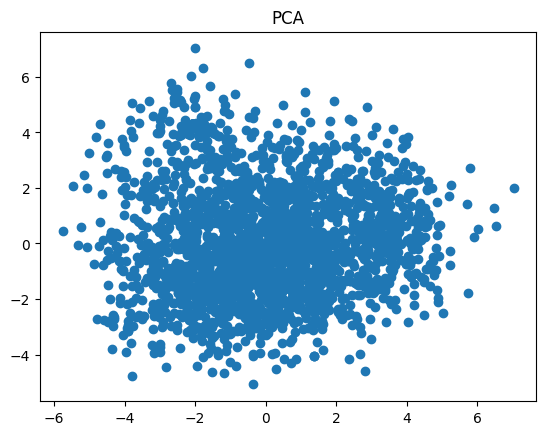

In [22]:
plt.title('PCA')
plt.scatter(sentence_pca[:,0], sentence_pca[:,1]);

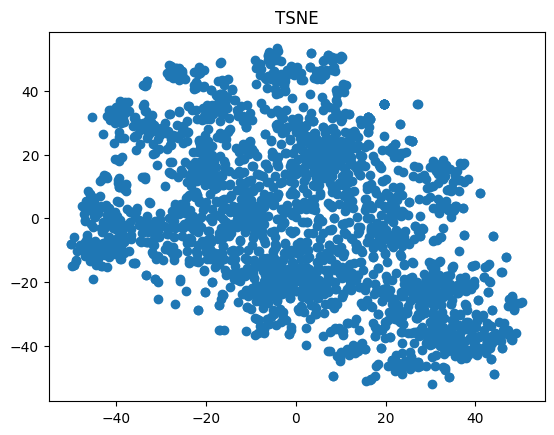

In [23]:
plt.title('TSNE')
plt.scatter(sentence_tsne[:,0], sentence_tsne[:,1]);

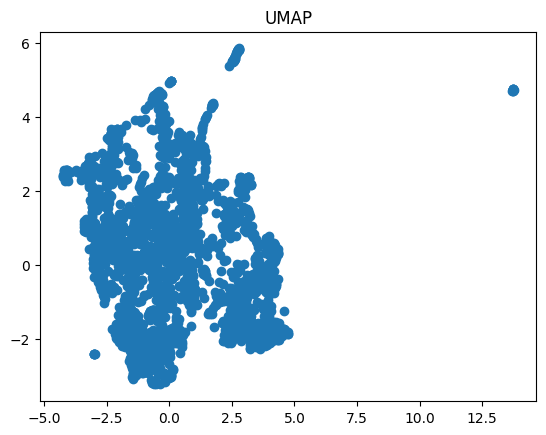

In [24]:
plt.title('UMAP')
plt.scatter(sentence_umap[:,0], sentence_umap[:,1]);

UMAP clusters look the most obvious, thus using it for dimensionality reduction

## Clustering

### Selecting number of clusters

Using silhouette score to find optimal number of clusters for KMeans:

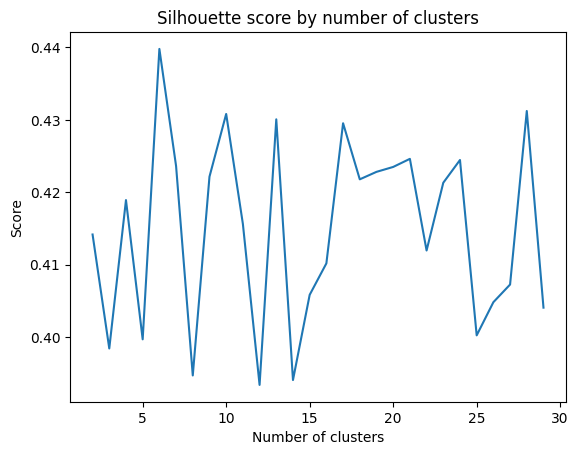

Best number of clusters: 6


In [25]:
kmeans_scores = []
for n_clusters in range(2, 30):
    kmeans_clusters = KMeans(n_clusters, n_init='auto').fit_predict(sentence_umap)
    kmeans_scores.append(metrics.silhouette_score(sentence_umap, kmeans_clusters))


plt.title('Silhouette score by number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.plot(range(2, 30), kmeans_scores)
plt.show()

best_n_clusters = range(2, 30)[np.argmax(kmeans_scores)]
print(f'Best number of clusters: {best_n_clusters}')

In [26]:
kmeans_clusters = KMeans(best_n_clusters, n_init='auto').fit_predict(sentence_umap)

In [27]:
def plot_clusters(sentences, clusters):
    for cluster in set(clusters):
        x = sentences[clusters == cluster, 0]
        y = sentences[clusters == cluster, 1]
        plt.scatter(x, y, label=cluster)

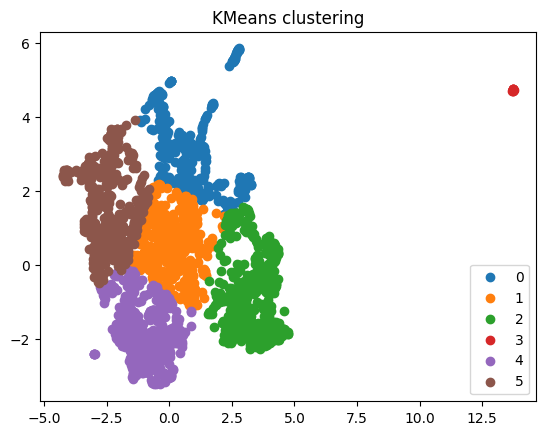

In [28]:
plt.title('KMeans clustering')
plot_clusters(sentence_umap, kmeans_clusters)
plt.legend();

KMeans clustering is not very good. Let's try HDBSCAN:

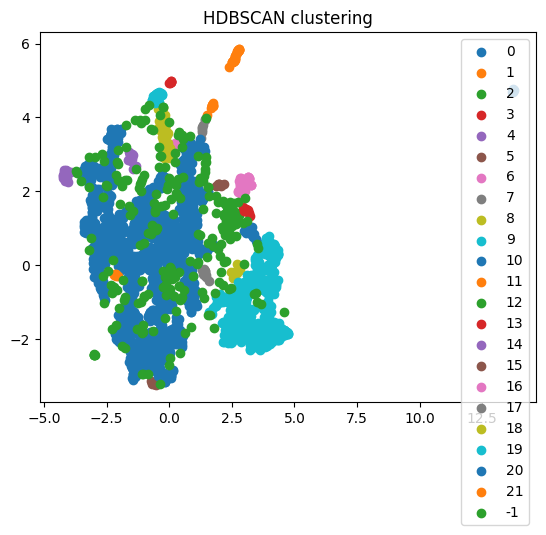

In [29]:
plt.title('HDBSCAN clustering')
hdbscan_clusters = HDBSCAN(cluster_selection_epsilon=0.2).fit_predict(sentence_umap)
plot_clusters(sentence_umap, hdbscan_clusters)
plt.legend();

### Examples of clustered content:

In [30]:
train_dataset[kmeans_clusters == 0]['content'].sample(5).to_list()

['Ночью было сбито над столицей более 10 БпЛА\n\nЗафиксировано падение обломков в Соломенском, Голосеевском и Святошинском районах Киева. Есть повреждения нежилых помещений и дорожного покрытия. Без серьезных разрушений и пожаров.\n\nКиев. Главное. Политика',
 '❗️Россияне запустили несколько групп "Шахедов" с аэродрома Приморско-Ахтарск\n\nКиев. Главное. Политика',
 'Опасно нынче в Броварах\n\nКиев. Главное. Политика',
 'В Бучанском районе сегодня проходит ликвидация взрывоопасных предметов\n\nЕсли услышите звуки взрывов, не пугайтесь.\n\nКиев. Главное. Политика',
 'В Киевской области только 5% отключений электричества произошли из-за обстрелов, — гендир ДТЭК Киевские региональные электросети Виталий Шайда\n\nПо его словам, остальные причины были такие:\n▪️50% отключений произошли из-за падения деревьев и веток;\n▪️20% из-за повреждения изношенного и устаревшего оборудования;\n▪️15% из-за повреждений в абонентских сетях.\n\nКиев. Главное. Политика']

In [31]:
train_dataset[hdbscan_clusters == 1]['content'].sample(5).to_list()

['Сегодня в Вышгородском районе пройдет ликвидация взрывоопасных предметов\n\nЕсли услышите звуки взрывов, не пугайтесь.\n\nКиев. Главное. Политика',
 '❗️Звуки взрывов, которые сегодня слышны в столице и области не несут угрозы.\n\nСегодня в Белоцерковском районе производится уничтожение взрывоопасных предметов.\n\nВзрывы могут доноситься как в столицу, так и в отдельные районы области. Поводов для волнения нет.\n\nКиев. Главное. Политика',
 'Сегодня в Вышгородского районе проходит ликвидация взрывоопасных предметов\n\nЕсли услышите звуки взрывов, не пугайтесь.\n\nКиев. Главное. Политика',
 'В Бучанском районе также проходит ликвидация взрывоопасных предметов. Может быть громко\n\nКиев. Главное. Политика',
 'Сегодня в Вышгородском районе проходит ликвидация взрывоопасных предметов\n\nЕсли услышите звуки взрывов, не пугайтесь.\n\nКиев. Главное. Политика']

Docs from one cluster have similar topics. Therefore topic clustering using HDBSCAN worked correctly.

## Topic modeling

For BERTopic will be used UMAP with n_components=10. Because UMAP will have more dims HDBSCAN epsilon will be 0.3.

Since train dataset is small, using BM25 weighting in c-TF-IDF.

To generate topic name from LDA keywords will be using bigscience/mt0-base model, because it knows ukrainian and russian.

In [32]:
class HDBSCANPred(HDBSCAN):
    def predict(self, x):
        return self.fit_predict(x)

In [33]:
topic_model = BERTopic(
    embedding_model=sentence_transformer_name,
    umap_model=UMAP(n_neighbors=15, n_components=10),
    hdbscan_model=HDBSCANPred(cluster_selection_epsilon=0.3),
    ctfidf_model=ClassTfidfTransformer(bm25_weighting=True),
    representation_model=TextGeneration(pipeline('text2text-generation', 'bigscience/mt0-base'),
                                        prompt='I have words, that describe topic of a text: [KEYWORDS]. What this topic is called in English?')
)

In [34]:
topics, probs = topic_model.fit_transform(train_dataset['processed_content'].to_list(), sentence_embeddings)

In [35]:
topic_model.get_topic_info()

Topic  Count                                Name  \
0      -1    481                          -1_kiev___   
1       0    596               0_Traffic accident___   
2       1    200                      1_buildings___   
3       2    174                      2_explosion___   
4       3     86                            3_smm___   
5       4     70                       4_military___   
6       5     61                    5_electricity___   
7       6     48                      6_sculpture___   
8       7     47                    7_agriculture___   
9       8     43                       8_donation___   
10      9     39                   9_independence___   
11     10     34                      10_forecast___   
12     11     32                    11_explosions___   
13     12     31                        12_Police___   
14     13     28                  13_thunderstorm___   
15     14     28                         14_boats___   
16     15     25                      15_military___   
17     16     24               16_political party___   
18     17     18            17_, , , , , , , , , ___   
19     18     18                      18_military___   
20     19     15         19_Where to go to visit?___   
21     20     14  20_Working in a foreign country___   
22     21     14                      21_Planning___   
23     22     13                        22_Animal___   
24     23     13                      23_portable___   
25     24     12                   24_electricity___   
26     25     10   25_rivers flow trough valleys.___   
27     26      9                     26_landscape___   
28     27      8                      27_military___   
29     28      8                          28_maps___   
30     29      8                    29_helicopter___   
31     30      7                        30_rivers___   
32     31      7                      31_lobotomy___   
33     32      7             32_emergency warning___   
34     33      6                      33_military___   
35     34      6                      34_military___   
36     35      6                   35_agriculture___   
37     36      6                      36_military___   
38     37      5                      37_gambling___   
39     38      5                      38_military___   
40     39      5                         39_event___   
41     40      5                         40_flood___   
42     41      5                      41_memorial___   
43     42      5              42_british military___   

                                      Representation  \
0                           [kiev, , , , , , , , , ]   
1               [Traffic accident, , , , , , , , , ]   
2                      [buildings, , , , , , , , , ]   
3                      [explosion, , , , , , , , , ]   
4                            [smm, , , , , , , , , ]   
5                       [military, , , , , , , , , ]   
6                    [electricity, , , , , , , , , ]   
7                      [sculpture, , , , , , , , , ]   
8                    [agriculture, , , , , , , , , ]   
9                       [donation, , , , , , , , , ]   
10                  [independence, , , , , , , , , ]   
11                      [forecast, , , , , , , , , ]   
12                    [explosions, , , , , , , , , ]   
13                        [Police, , , , , , , , , ]   
14                  [thunderstorm, , , , , , , , , ]   
15                         [boats, , , , , , , , , ]   
16                      [military, , , , , , , , , ]   
17               [political party, , , , , , , , , ]   
18            [, , , , , , , , , , , , , , , , , , ]   
19                      [military, , , , , , , , , ]   
20         [Where to go to visit?, , , , , , , , , ]   
21  [Working in a foreign country, , , , , , , , , ]   
22                      [Planning, , , , , , , , , ]   
23                        [Animal, , , , , , , , , ]   
24                      [portable, , , , , , , , , ]   
25                   [elect

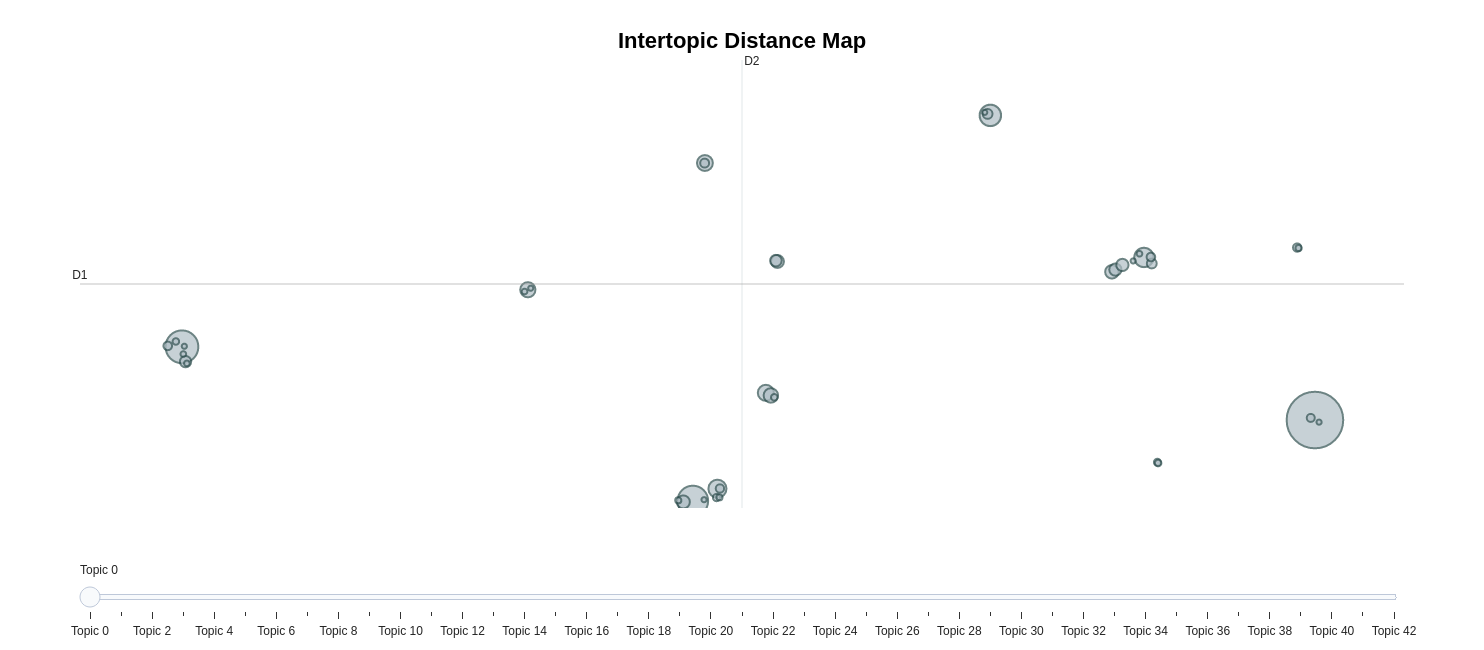

In [36]:
topic_model.visualize_topics()

As we can see, some topics are repeated many times.

Possible solution for this problem is to add more channels with different topics, increase epsilon in HDBSCAN to merge similar clusters, and
to use bigger representation model to generate better topic names.

## Predicting channel topics

In [37]:
def predict_corpus_topics(topic_model, corpus, n_doc_to_check=None, n_topics=None):
    if n_doc_to_check == None:
        n_doc_to_check = len(corpus)

    corpus = np.array(corpus)
    
    checked_doc_id = random.sample(range(0, len(corpus)), min(len(corpus), n_doc_to_check))
    
    topic_ids, prob = topic_model.transform(corpus[checked_doc_id])
    
    unique_topic_ids, id_count = np.unique(topic_ids, return_counts=True)

    sorted_topic_ids = list(reversed(unique_topic_ids[np.argsort(id_count)]))

    if n_topics is not None:
        sorted_topic_ids = sorted_topic_ids[:n_topics]
    
    topic_names = []
    for topic_id in sorted_topic_ids:
        topic_names.append(topic_model.get_topic_info(topic_id)['Name'].iloc[0])
        
    return topic_names

### Predicting topics for train channels

In [38]:
train_channel_topics = {}
for channel in list(set(selected_channels)):
    channel_docs = dataset[dataset['channelname'] == channel]['processed_content'].to_list()
    train_channel_topics[channel] = predict_corpus_topics(topic_model, channel_docs, n_doc_to_check=500, n_topics=5)
train_channel_topics

{'dailykek': ['17_, , , , , , , , , ___', '11_explosions___'],
 'tsum6': ['11_explosions___', '-1_kiev___', '17_, , , , , , , , , ___'],
 'hmarochos': ['23_portable___',
  '-1_kiev___',
  '5_electricity___',
  '17_, , , , , , , , , ___',
  '38_military___'],
 'kyivpolitics': ['2_explosion___',
  '-1_kiev___',
  '17_, , , , , , , , , ___',
  '38_military___',
  '24_electricity___'],
 'pro_mobility': ['11_explosions___',
  '36_military___',
  '25_rivers flow trough valleys.___',
  '-1_kiev___',
  '17_, , , , , , , , , ___']}

### Predicting topics for first 10 channels in the dataset

In [39]:
channel_topics = {}
for channel in list(set(dataset['channelname']))[:10]:
    channel_docs = dataset[dataset['channelname'] == channel]['processed_content'].to_list()
    channel_topics[channel] = predict_corpus_topics(topic_model, channel_docs, n_doc_to_check=200, n_topics=5)
channel_topics

{'va_kyiv': ['-1_kiev___',
  '11_explosions___',
  '17_, , , , , , , , , ___',
  '36_military___'],
 'kievvlast': ['-1_kiev___',
  '19_Where to go to visit?___',
  '23_portable___',
  '25_rivers flow trough valleys.___',
  '22_Animal___'],
 'lisovy_masyv_official': ['-1_kiev___',
  '23_portable___',
  '10_forecast___',
  '37_gambling___',
  '19_Where to go to visit?___'],
 'kyiv_novyny_24': ['-1_kiev___',
  '19_Where to go to visit?___',
  '5_electricity___',
  '10_forecast___',
  '17_, , , , , , , , , ___'],
 'hmarochos': ['25_rivers flow trough valleys.___',
  '5_electricity___',
  '-1_kiev___',
  '11_explosions___',
  '17_, , , , , , , , , ___'],
 'tsegla_news': ['11_explosions___',
  '36_military___',
  '-1_kiev___',
  '17_, , , , , , , , , ___'],
 'khreschatyk36': ['11_explosions___',
  '-1_kiev___',
  '36_military___',
  '17_, , , , , , , , , ___'],
 'kyivpolitics': ['11_explosions___',
  '-1_kiev___',
  '17_, , , , , , , , , ___',
  '36_military___'],
 'pro_mobility': ['11_explo

From predictions we can see, that all channels have posts on similar topics.
Therefore, to improve BERTopic it is necessary to add channels with more diverse topics to train dataset.